In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

import gc
import pickle as pickle

from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
import multiprocessing as mp
import importlib
from sklearn.model_selection import train_test_split

In [3]:
#tail -n +2 train.csv | split -l 150000


In [4]:
from os import listdir
from os.path import isfile, join

TRAIN_SPLITS='train'
splits = [f for f in listdir(TRAIN_SPLITS) if isfile(join(TRAIN_SPLITS, f))]

In [10]:
path = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df = pd.read_csv(path, float_precision='round_trip', header=None)
df.columns = columns

df.describe()

,acoustic_data,time_to_failure
count,150000.000000,150000.000000
mean,4.265593,8.269593
std,4.765394,0.011250
min,-95.000000,8.250297
25%,2.000000,8.259898
50%,4.000000,8.269498
75%,6.000000,8.279099
max,102.000000,8.288600


In [15]:
mu = df['acoustic_data'].mean()
sigma = df['acoustic_data'].std()



df['noise'] = np.random.normal(mu, sigma,df.shape[0]) 

In [25]:
a = np.random.choice(df.index.values, 5)

In [29]:
df.loc[a,'acoustic_data'] = [1,2,3,4,5]

In [30]:
df.loc[a]

,acoustic_data,time_to_failure,noise
20696,1,8.283299,2.720708
74660,2,8.269499,-0.271697
21406,3,8.283299,11.993588
66986,4,8.271598,6.318928
42244,5,8.277998,-3.042803


In [28]:
df.sample(10)

,acoustic_data,time_to_failure,noise
54125,-3,8.274799,-0.170265
110276,0,8.260996,3.785144
38879,8,8.279097,7.336568
137386,5,8.253497,-2.779585
7995,4,8.286500,7.963051
53761,7,8.274799,5.206746
64961,7,8.272696,8.588233
146951,8,8.251396,1.333524
120092,1,8.257798,9.548633
83182,2,8.267298,3.744134


In [ ]:
path1 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df1 = pd.read_csv(path1, float_precision='round_trip', header=None)
df1.columns = columns

path2 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df2 = pd.read_csv(path2, float_precision='round_trip', header=None)
df2.columns = columns

In [ ]:
np.random.choice(np.array([1,2,3,4]))
for i in range(0,20):
    print(i)

In [ ]:
acoustic_data = np.array_split(df['acoustic_data'].values, 300)

np.random.choice(acoustic_data[0])

In [ ]:

#last_n=int(SEGMENT_LENGTH/timesteps/4)
acoustic_data = np.array_split(df['acoustic_data'].values, 500)
#means = np.array([np.mean(sub[-last_n:], dtype=np.float64) for sub in acoustic_data])
data = np.array([(np.mean(sub),np.max(sub),np.min(sub)) for sub in acoustic_data])
target = df['time_to_failure'].values[-1]
#
df2 = pd.DataFrame(data)
df2.columns = ["mean", "max", "min"]

In [ ]:
df2

In [ ]:
a = np.array([1,2,-3,4,50,-1,2,3])
a[a > 3]

In [46]:
TIMESTEPS=100

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

split_chunks = np.array_split(splits,mp.cpu_count())

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS,False,True]) for chunk in split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300
400
400
400
400
400
400
400
400
500
500
500
500
500
500
500
500


In [37]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

res[0].get()[100]

,mean,max,min,std,abs,q25,q50,q75,sum,uniq,pos,negs,ssum,imax,imin,abs_nrg,abs_sum_chg,autocorr_10,cid_ce,kurtosis,mean_chg,reocurring_pct,r_sigma,ratio_to_length,skewness,time_to_failure
0,-1.039167,-0.145707,0.306304,-0.047043,-0.224211,-0.440142,-1.166693,0.695641,-1.039167,-0.277882,-0.745476,0.553856,-0.335682,-0.115914,0.783764,-0.235939,0.136855,0.240818,0.051142,-0.445704,1.334611,-0.406435,0.146848,-0.277882,-0.380075,13.690099
1,0.456842,-0.187006,0.403903,-0.120885,-0.292924,-0.440142,0.377446,0.695641,0.456842,0.466445,0.089557,-0.076293,-0.044654,0.068041,-1.519217,-0.129817,0.393554,0.520899,0.834070,-0.264857,-0.568756,-0.702716,1.221349,0.466445,0.595015,13.690099
2,0.022805,-0.358194,0.459364,-0.206177,-0.410582,-0.440142,-0.416740,0.211948,0.022805,-0.426748,0.089557,-0.098798,-0.265096,1.270478,0.141118,-0.227941,0.090223,0.318829,0.597590,-0.347317,0.957401,-0.395857,1.221349,-0.426748,0.739784,13.690099
3,0.423905,-0.114992,0.036628,-0.064254,-0.078734,-0.440142,0.728378,0.695641,0.423905,-0.277882,0.173061,0.306297,0.097311,0.023174,0.281000,-0.097346,0.265157,0.404245,0.602020,-0.033157,0.002028,-0.531916,1.340738,-0.277882,0.018074,13.690099
4,-0.014118,-0.075109,0.165590,-0.086858,-0.119262,-0.440142,0.187095,0.553666,-0.014118,-0.327504,-0.160953,0.306297,-0.035897,0.682719,-0.379890,-0.157331,0.409169,0.310814,0.995776,-0.145632,0.031466,-0.528609,0.624404,-0.327504,-0.305658,13.690099
5,-0.200533,-0.295748,0.090645,-0.210142,-0.200792,-0.440142,-0.182369,0.695641,-0.200533,-2.014646,0.026930,-0.008777,-0.265639,0.976599,1.349372,-0.253376,0.293447,1.442883,1.156028,-0.257586,-0.626299,-0.409282,0.385626,-2.014646,-0.868629,13.690099
6,-0.311373,0.014015,0.191286,-0.103667,-0.084138,-0.440142,-0.356153,-0.016543,-0.311373,-0.575613,-0.119201,0.081244,-0.160166,-0.645345,-0.420436,-0.198535,0.271206,0.037215,0.691533,-0.026968,-1.240237,-0.638638,0.863182,-0.575613,-0.118538,13.690099
7,-0.479316,0.098469,0.146154,-0.128449,-0.017583,-0.440142,-0.842646,-0.511566,-0.479316,-1.667294,-0.098325,0.103749,-0.284951,0.570552,1.014873,-0.231267,0.295268,0.860563,0.938976,-0.019338,-0.098002,-0.434993,-0.330707,-1.667294,0.311152,13.690099
8,0.699403,0.033664,0.079536,0.341733,-0.020170,-0.440142,1.644916,0.695641,0.699403,0.615311,-1.079490,1.161499,0.497932,0.958652,-1.190799,0.207638,0.773358,-0.859323,-0.145511,-0.358792,-0.660140,0.263468,-0.091930,0.615311,0.136772,13.690099
9,0.389916,0.029918,-0.137641,-0.059787,0.081830,-0.440142,0.586760,0.695641,0.389916,-0.674857,-0.390587,0.238781,-0.044504,0.516711,-1.490835,-0.098045,0.547818,0.906694,0.807616,-0.307184,2.624732,-0.505147,0.027459,-0.674857,0.298417,13.690099


In [47]:
NUMBER_OF_FEATURES=len(res[0].get()[0].drop('time_to_failure', axis=1).columns)

training = np.empty((len(splits)*2,TIMESTEPS,NUMBER_OF_FEATURES),dtype=float)
targets = np.empty((len(splits)*2,1),dtype=float)
i=0
for r in res:
    for df in r.get():
        training[i] = df.drop('time_to_failure', axis=1)
        targets[i] = np.array([df['time_to_failure'].unique()])
        i+=1

In [ ]:
res[0].get()[0]

In [ ]:
res[0].get()[0][['acoustic_data', 'rolling_10', 'rolling_50', 'rolling_100', 'min_50',
       'max_50', 'std_50']].shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 16)                2016      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,033
Trainable params: 2,033
Non-trainable params: 0
_________________________________________________________________
Train on 7551 samples, validate on 839 samples
Epoch 1/100
7551/7551 [==============================] - 16s 2ms/step - loss: 3.4160 - mean_absolute_error: 3.4160 - val_loss: 3.0340 - val_mean_absolute_error: 3.0340
Epoch 2/100
7551/7551 [==============================] - 17s 2ms/step - loss: 2.8135 - mean_absolute_error: 2.8135 - val_loss: 2.5489 - val_mean_absolute_error: 2.5489
Epoch 3/100
7551/7551 [==============================] - 18s 2ms/step - loss: 2.4022 - mean_absolute_error: 2.4022 - val_loss: 2.2805 - val_mean_absolute

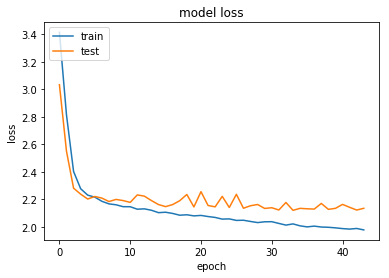

In [48]:
train_data, val_data, y_train, y_val = train_test_split(training, targets, test_size=0.1, random_state=42)

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,GRU#,CuDNNGRU,CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional



dropout=0.2
BATCH_SIZE=16


my_model = Sequential()


my_model.add(GRU(use_bias = True,#unit_forget_bias=True,\
                  units = 16,\
                  input_shape=(TIMESTEPS, NUMBER_OF_FEATURES),
                  #dropout=dropout,recurrent_dropout=dropout,
                  #return_sequences=True
                  ))

#my_model.add(BatchNormalization())


                 
                    
#my_model.add(Dense(8))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mae',optimizer = 'adam', metrics = ['mean_absolute_error'])
my_model.summary()

from keras.callbacks import Callback

class Reseter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.reset_states()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0),
    #Reseter()
]

history = my_model.fit(train_data, y_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True,
                      validation_data=(val_data,y_val), callbacks=callbacks
                    )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#import math
#print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [41]:
TEST_SPLITS='test'
test_splits = [f for f in listdir(TEST_SPLITS) if isfile(join(TEST_SPLITS, f))]

In [ ]:
test_splits

In [49]:
test_split_chunks = np.array_split(test_splits,mp.cpu_count())

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS, True]) \
           for chunk in test_split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300


In [50]:
ids = []
preds = []
i=0
for r in res:
    for df in r.get():
        if i % 100 == 0:
            print(i)
        #training[i] = df.loc[:,df.columns != 'time_to_failure']
        ids.append(df['seg_id'].unique()[0].split(".")[0])
        test_df = df.drop('seg_id', axis=1)
        preds.append(my_model.predict(test_df.values.reshape(1,-1,NUMBER_OF_FEATURES))[0][0])
        i+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [51]:
submission = pd.DataFrame(ids)
submission.columns = ['seg_id']
submission['time_to_failure'] = preds

submission.to_csv('submission.csv', index=False)

In [45]:
submission["time_to_failure"].describe()

count    2624.000000
mean     5.234952   
std      2.658105   
min     -0.397661   
25%      2.985751   
50%      4.613823   
75%      7.828412   
max      10.344594  
Name: time_to_failure, dtype: float64

In [52]:
submission["time_to_failure"].describe()

count    2624.000000
mean     5.322992   
std      2.626039   
min     -0.497457   
25%      3.176856   
50%      4.755400   
75%      7.700604   
max      10.682412  
Name: time_to_failure, dtype: float64

In [ ]:
submission.head()

In [ ]:
preds

In [ ]:
res[0].get()[0]

In [ ]:
path = 'test/%s' % (np.random.choice(test_splits))
#

df = pd.read_csv(path, float_precision='round_trip', header=[0])


df.describe()